In [15]:
import pandas as pd
import numpy as np
from scipy.optimize import brute


In [4]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                   index_col=0, parse_dates=True).dropna()

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [6]:
data = pd.DataFrame(raw['EUR='])

In [7]:
data.rename(columns={'EUR=': 'price'}, inplace=True)

In [9]:
data['price'].rolling(42).mean()

Date
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
                ...   
2019-12-24    1.107698
2019-12-26    1.107740
2019-12-27    1.107924
2019-12-30    1.108131
2019-12-31    1.108279
Name: price, Length: 2516, dtype: float64

In [10]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

In [11]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


In [12]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

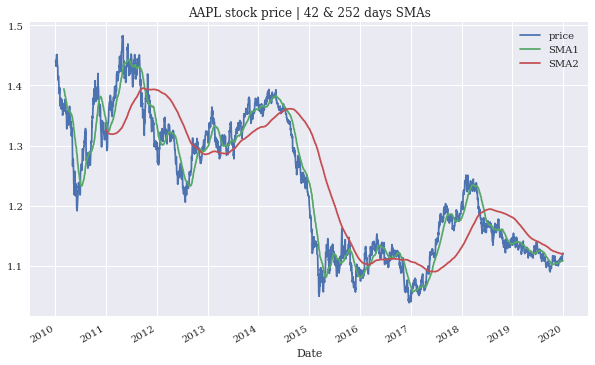

In [13]:
data.plot(title='EUR/USD | 42 & 252 days SMAs',
          figsize=(10, 6));

In [16]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [18]:
data.dropna(inplace=True)

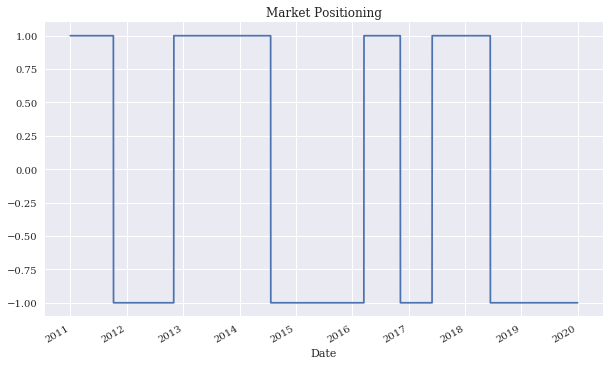

In [19]:
data['position'].plot(ylim=[-1.1, 1.1],
                      title='Market Positioning',
                      figsize=(10, 6));

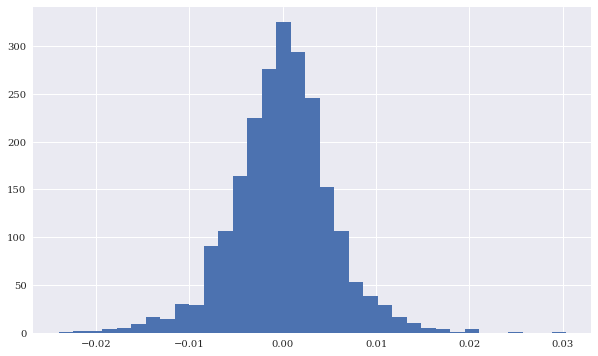

In [46]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data['returns'].hist(bins=35, figsize=(10, 6));

In [47]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].sum()

returns    -0.176731
strategy    0.253121
dtype: float64

In [48]:
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

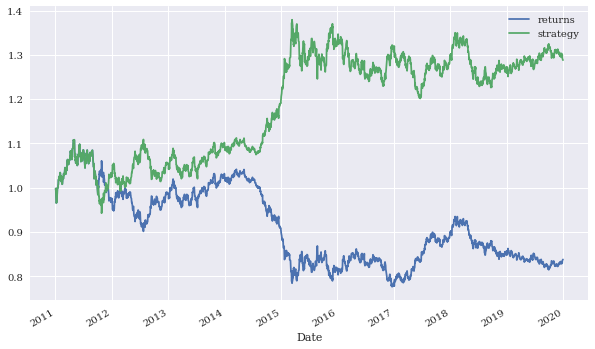

In [38]:
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

In [49]:
data[['returns', 'strategy']].mean() * 252


returns    -0.019671
strategy    0.028174
dtype: float64

In [50]:
data[['returns', 'strategy']].std() * 252 ** 0.5


returns     0.085414
strategy    0.085405
dtype: float64

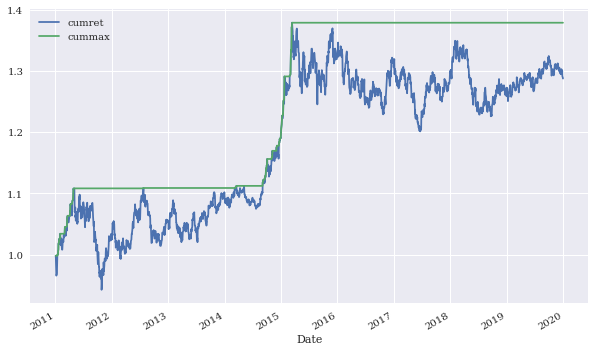

In [54]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)
data['cummax'] = data['cumret'].cummax()
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6));
drawdown = data['cummax'] - data['cumret']


In [60]:
drawdown[drawdown == drawdown.max()].index[0]

Timestamp('2017-06-20 00:00:00')

In [75]:
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

periods.max()

datetime.timedelta(days=596)

In [79]:
class SMAVectorBacktester(object):
    ''' Class for the vectorized backtesting of SMA-based trading strategies.
    Attributes
    ==========
    symbol: str
        RIC symbol with which to work with
    SMA1: int
        time window in days for shorter SMA
    SMA2: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    set_parameters:
        sets one or two new SMA parameters
    run_strategy:
        runs the backtest for the SMA-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    update_and_run:
        updates SMA parameters and returns the (negative) absolute performance
    optimize_parameters:
        implements a brute force optimizeation for the two SMA parameters
    '''

    def __init__(self, symbol, SMA1, SMA2, start, end):
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        raw['SMA1'] = raw['price'].rolling(self.SMA1).mean()
        raw['SMA2'] = raw['price'].rolling(self.SMA2).mean()
        self.data = raw

    def set_parameters(self, SMA1=None, SMA2=None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(
                self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()

    def run_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # gross performance of the strategy
        aperf = data['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | SMA1=%d, SMA2=%d' % (self.symbol,
                                               self.SMA1, self.SMA2)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))

    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns negative absolute performance
        (for minimazation algorithm).
        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.
        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)


if __name__ == '__main__':
    smabt = SMAVectorBacktester('EUR=', 42, 252,
                                '2010-1-1', '2020-12-31')
    print(smabt.run_strategy())
    smabt.set_parameters(SMA1=20, SMA2=100)
    print(smabt.run_strategy())
    print(smabt.optimize_parameters((30, 56, 4), (200, 300, 4)))


(1.29, 0.45)
(0.97, 0.05)
(array([ 50., 236.]), 1.49)


In [81]:
import SMAVectorBacktester as SMA


ModuleNotFoundError: No module named 'SMAVectorBacktester'

In [80]:
smabt = SMA.SMAVectorBacktester('EUR=', 42, 252,
                                '2010-1-1', '2019-12-31') 

NameError: name 'SMA' is not defined